# Comparison models to test the CatBoost against other models
Predictions of Lymphocytes, tumorogenesis???

- 1.) ElasticNet
- 2.) Support Vector Regression
- 3.) Mixed linear modeling
- 4.) XGBoost
- 5.) DL model???

In [1]:
### Using monkey_env/ ###
### If giving a tqb error, run this code twice###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#language handling
#import bert

#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

print("Setup Complete")


/Users/aidanlew/Desktop/cmb/codes/monkey_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete


In [5]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [7]:
#Makee a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    #date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Cannot parse header or footer so it will be ignored


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

# ElasticNet
- All inputs have to be numeric
- Can't handle NaN
- It looks like it works but I think something is up

In [3]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet

In [8]:
minbio_monkey_df.head(2)

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,2017-12-20,No,NaT,2007-05-14,F,Clinical,NaN,NaN,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,2018-01-29,No,NaT,2007-05-14,F,Research,NaN,NaN,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [19]:
#count control monkeys
print('Non-Irradiated Samples:{}'.format(minbio_monkey_df['IRRAD'].value_counts()['No']))
 
# Count the irradiated monkeys
print('Irradiated Samples:{}'.format(minbio_monkey_df['IRRAD'].value_counts()['Yes']))

#Count Males
print('Males:{}'.format(minbio_monkey_df['SEX'].value_counts()['M']))
 
# Count females
print('Females:{}'.format(minbio_monkey_df['SEX'].value_counts()['F']))


Non-Irradiated Samples:970
Irradiated Samples:3582
Males:3608
Females:944


In [39]:
#make a parent df
minbio_monkey_df.copy()
elnet_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
elnet_df=elnet_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
elnet_df['SEX'] = elnet_df['SEX'].map({'M':1, 'F': 0})
elnet_df['IRRAD'] = elnet_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
elnet_df['DOSE_(Gy)'] = elnet_df['DOSE_(Gy)'].fillna(0)
elnet_df['DAYS_SINCE_IRRAD'] = elnet_df['DAYS_SINCE_IRRAD'].fillna(0)
elnet_df['MONTHS_SINCE_IRRAD'] = elnet_df['MONTHS_SINCE_IRRAD'].fillna(0)
elnet_df['MONTHS AT IRRAD'] = elnet_df['MONTHS AT IRRAD'].fillna(0)

elnet_df.head(5)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,0.0,0.0,0.0,10.6,10.9,5.05,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,0.0,0.0,0.0,10.7,8.8,4.59,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334
2,2061,0,0,0.0,0.0,0.0,0.0,10.9,17.5,4.74,...,8.5,3.4,0.1,0.1,15383,1488,595,18,18,321
3,2061,0,0,0.0,0.0,0.0,0.0,11.3,21.1,4.76,...,5.5,2.7,0.1,0.0,19349,1161,570,21,0,310
4,2061,0,0,0.0,0.0,0.0,0.0,11.6,11.5,4.53,...,14.5,6.6,0.1,0.0,9062,1668,759,12,0,486


In [40]:
#count control monkeys
print('Non-Irradiated Samples:{}'.format(elnet_df['IRRAD'].value_counts()[0]))
 
# Count the irradiated monkeys
print('Irradiated Samples:{}'.format(elnet_df['IRRAD'].value_counts()[1]))

#Count Males
print('Males:{}'.format(elnet_df['SEX'].value_counts()[1]))
 
# Count females
print('Females:{}'.format(elnet_df['SEX'].value_counts()[0]))

Non-Irradiated Samples:970
Irradiated Samples:3582
Males:3608
Females:944


## With the NaN converted to 0

In [94]:
y=elnet_df['LYMPHOCYTES_(%)']
X=elnet_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

data= train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_validation, y_train, y_validation= data

train_pool = Pool(
    data = X_train,
    label = y_train
)


validation_pool = Pool(
    data = X_validation,
    label = y_validation,
)


iteritems is deprecated and will be removed in a future version. Use .items instead.


In [95]:

# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# fit model
model.fit(X_train, y_train)

ElasticNet()

Plot Title: t


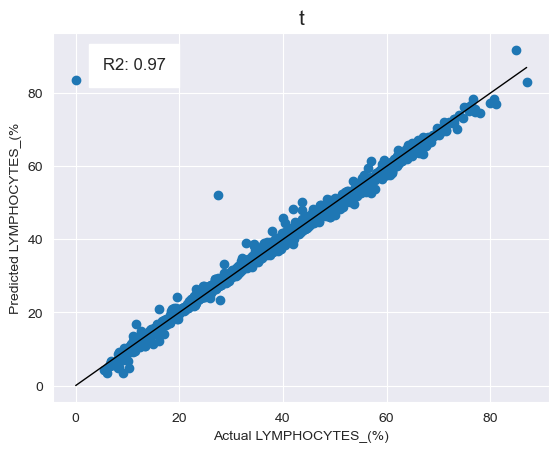

In [96]:
# make a prediction
a = model.predict(X_validation)
a_df = pd.DataFrame(a)


### Plotting ###
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(y_validation, a_df)

ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)

plt.show() 


## Without NaN converted to 0

In [100]:
#make a parent df
minbio_monkey_df.copy()
no_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
no_df=no_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE','DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
no_df['SEX'] = no_df['SEX'].map({'M':1, 'F': 0})
no_df['IRRAD'] = no_df['IRRAD'].map({'Yes':1, 'No': 0})
no_df['DOSE_(Gy)'] = no_df['DOSE_(Gy)'].fillna(0)

no_df.head(2)

,ID,IRRAD,SEX,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),Hemocrit_(HCT_%),Mean_corpuscular_volume_(MCV_fL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,10.6,10.9,5.05,12.0,35.7,70.69,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,10.7,8.8,4.59,10.5,33.3,72.55,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [101]:
y=no_df['LYMPHOCYTES_(%)']
X=no_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

data= train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_validation, y_train, y_validation= data

train_pool = Pool(
    data = X_train,
    label = y_train
)


validation_pool = Pool(
    data = X_validation,
    label = y_validation,
)

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [102]:
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# fit model
model.fit(X_train, y_train)

ElasticNet()

Plot Title: t


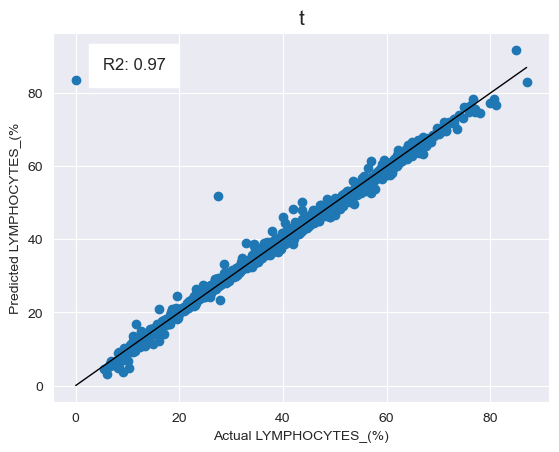

In [103]:
# make a prediction
a = model.predict(X_validation)
a_df = pd.DataFrame(a)


### Plotting ###
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(y_validation, a_df)

ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)

plt.show() 


# Support Vector Regression

# XGBoost
- No catagorical
- Needs a lot of tuning

In [107]:
import xgboost as xgb
from xgboost import XGBRegressor

In [109]:
#make a parent df
minbio_monkey_df.copy()
xg_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
xg_df=xg_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
xg_df['SEX'] = xg_df['SEX'].map({'M':1, 'F': 0})
xg_df['IRRAD'] = xg_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
xg_df['DOSE_(Gy)'] = xg_df['DOSE_(Gy)'].fillna(0)

In [112]:
y=no_df['LYMPHOCYTES_(%)']
X=no_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
model.fit(X_train, y_train)
  
# Predict the model
a = model.predict(X_validation)
a_df = pd.DataFrame(a)

Plot Title: t


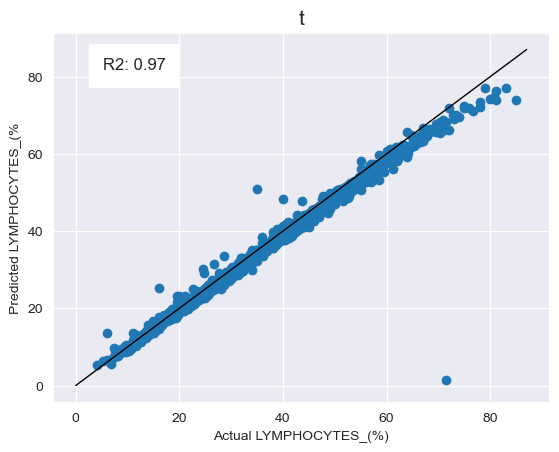

In [113]:
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(y_validation, a_df)

ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)

plt.show() 


# DL model